In [1]:
import warnings
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import os
import sys

from glob import glob

import numpy as np

import itk
import matplotlib.pyplot as plt

import argparse

import ubelt as ub

import site
site.addsitedir('../../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  # NOQA

import pint
Ureg = pint.UnitRegistry()

In [2]:
class pocus_ai_pnb_needle_network:
    
    def __init__(self, img_dir, anno_dir, device_num, run_id):
        self.device_num = device_num
        self.run_id = run_id
        
        self.all_images = sorted(glob(os.path.join(img_dir, '*_cropM.mha')))
        self.all_labels = sorted(glob(os.path.join(anno_dir, '*.overlay.mha')))

        total_bytes = 0
        for p in self.all_images:
            p = ub.Path(p)
            total_bytes += p.stat().st_size
        print((total_bytes * Ureg.byte).to('GiB'))

        total_bytes = 0
        for p in self.all_labels:
            p = ub.Path(p)
            total_bytes += p.stat().st_size
        print((total_bytes * Ureg.byte).to('GiB'))

        self.num_folds = 10

        self.num_classes = 3

        self.max_epochs = 1500

        self.net_dims = 2 # Spatial Dimensions
        self.net_in_channels = 6 # Mean, Std, RawFrame
        self.net_channels=(16, 32, 64, 128, 32)
        self.net_strides=(2, 2, 2, 2)

        self.num_workers_train = 1
        self.batch_size_train = 12
        
        self.num_workers_val = 1
        self.batch_size_val = 2

        self.num_slices = 16
        self.size_x = 320
        self.size_y = 640

        #filename_base = os.path.basename(__file__)
        filename_base = "ARUNet-NeedleArtery-VFold-Training"
        self.model_filename_base = "./Results/"+filename_base+"-"+str(self.num_slices)+"s-VFold-Run"+str(self.run_id)

        if not os.path.exists(self.model_filename_base):
            os.makedirs(self.model_filename_base)
        self.model_filename_base = self.model_filename_base+"/"

    def setup_data_files(self):
        num_images = len(self.all_images)
        print("Num images / labels =", num_images, len(self.all_labels))

        # 46 ok
        # 178 bad
        # 207 ok
        # 230 ok
        # 54 ok
        p_prefix = [' 11',
                ' 46',
                ' 207',
                ' 67', 
                ' 93', 
                ' 94', 
                ' 134', 
                ' 211', 
                ' 222A',  
                ' 153', 
                ' 240',  
                ' 193']
        n_prefix = [' 57',
                ' 136', 
                ' 179', 
                ' 189', 
                ' 204', 
                ' 205', 
                ' 217', 
                ' 238',  
                ' 39',
                ' 230',
                ' 54',
                ' 191']

        fold_prefix_list = []
        p_count = 0
        n_count = 0
        for i in range(self.num_folds):
            num_p = 1
            num_n = 1
            if i > self.num_folds-5:
                if i%2 == 0:
                    num_p = 2
                    num_n = 1
                else:
                    num_p = 1
                    num_n = 2
            f = []
            if p_count < len(p_prefix):
                for p in range(num_p):
                    f.append([p_prefix[p_count+p]])
            p_count += num_p
            if n_count < len(n_prefix):
                for n in range(num_n):
                    f.append([n_prefix[n_count+n]])
            n_count += num_n
            fold_prefix_list.append(f)

        for i in range(self.num_folds):
            print(i, fold_prefix_list[i])

        self.train_files = []
        self.val_files = []
        self.test_files = []

        for i in range(self.num_folds):
            tr_folds = []
            va_folds = []
            for f in range(i,i+self.num_folds-3):
                tr_folds.append(fold_prefix_list[f % self.num_folds])
            tr_folds = list(np.concatenate(tr_folds).flat)
            for f in range(i+self.num_folds-3, i+self.num_folds-1):
                va_folds.append(fold_prefix_list[f % self.num_folds])
            va_folds = list(np.concatenate(va_folds).flat)
            te_folds = list(np.concatenate(
                fold_prefix_list[(i+self.num_folds-1) % self.num_folds]).flat)
            self.train_files.append(
                [ {"image": img, "label": seg}
                    for img, seg in zip(
                        [im for im in self.all_images if
                             any(pref in im for pref in tr_folds)],
                        [se for se in self.all_labels if
                             any(pref in se for pref in tr_folds)])
                ] )
            self.val_files.append(
                [ {"image": img, "label": seg}
                    for img, seg in zip(
                        [im for im in self.all_images if
                            any(pref in im for pref in va_folds)],
                        [se for se in self.all_labels if
                            any(pref in se for pref in va_folds)])
                ] )
            self.test_files.append(
                [ {"image": img, "label": seg}
                    for img, seg in zip(
                        [im for im in self.all_images if
                            any(pref in im for pref in te_folds)],
                        [se for se in self.all_labels if
                            any(pref in se for pref in te_folds)])
                    ]
                )
            print(len(self.train_files[i]),len(self.val_files[i]),len(self.test_files[i]))

                
    def setup_data_transforms(self):
        self.train_transforms = Compose(
            [
            LoadImaged(keys=["image", "label"]),
            AsChannelFirstd(keys='image'),
            AsChannelFirstd(keys='label'),
            ScaleIntensityRanged(
                a_min=0, a_max=255,
                b_min=0.0, b_max=1.0,
                keys=["image"]),
            ARGUS_RandSpatialCropSlicesd(
                num_slices=[self.num_slices,1],
                axis=0,
                reduce_to_statistics=[True,False],
                require_labeled=True,
                extended=False,
                include_center_slice=True,
                include_mean_abs_diff=True,
                include_skewness=True,
                include_kurtosis=True,
                include_gradient=True,
                keys=['image','label']),
            Resized(
                spatial_size=(-1,self.size_y),
                mode=["bilinear","nearest"],
                keys=['image','label']),
            RandSpatialCropd(
                roi_size=(self.size_x,self.size_y),
                random_center=True,
                random_size=False,
                keys=['image','label']),
            RandFlipd(prob=0.5, 
                spatial_axis=0,
                keys=['image', 'label']),
            ToTensord(keys=["image", "label"]),
            ] )
        
        self.val_transforms = Compose(
            [
            LoadImaged(keys=["image", "label"]),
            AsChannelFirstd(keys='image'),
            AsChannelFirstd(keys='label'),
            ScaleIntensityRanged(
                a_min=0, a_max=255,
                b_min=0.0, b_max=1.0,
                keys=["image"]),
            ARGUS_RandSpatialCropSlicesd(
                num_slices=[self.num_slices,1],
                center_slice=-self.num_slices/2 - 1,
                axis=0,
                reduce_to_statistics=[True,False],
                extended=False,
                include_center_slice=True,
                include_gradient=True,
                keys=['image','label']),
            Resized(
                spatial_size=(-1,self.size_y),
                mode=["bilinear","nearest"],
                keys=['image','label'])
            ] )

        self.device = torch.device("cuda:"+str(self.device_num))

    def setup_vfold(self, vfold_num):
        train_ds = CacheDataset(data=self.train_files[vfold_num],
            transform=self.train_transforms,
            cache_rate=0.1,
            num_workers=self.num_workers_train)
        self.train_loader = DataLoader(train_ds,
            batch_size=self.batch_size_train,
            shuffle=True,
            num_workers=self.num_workers_train)

        val_ds = CacheDataset(data=self.val_files[vfold_num],
            transform=self.val_transforms,
            cache_rate=0.1,
            num_workers=self.num_workers_val)
        self.val_loader = DataLoader(val_ds,
            batch_size=self.batch_size_val,
            num_workers=self.num_workers_val)

    def train_network_vfold(self, vfold_num):
        self.model = UNet(
            dimensions=self.net_dims,
            in_channels=self.net_in_channels,
            out_channels=self.num_classes,
            channels=self.net_channels,
            strides=self.net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
            ).to(self.device)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        optimizer = torch.optim.Adam(self.model.parameters(), 1e-4)
        dice_metric = DiceMetric(include_background=False, reduction="mean")

        val_interval = 2

        self.best_metric = -1
        self.best_metric_epoch = -1
        self.epoch_loss_values = []
        self.metric_values = []

        post_pred = Compose([EnsureType(),
            AsDiscrete(argmax=True, to_onehot=True, num_classes=self.num_classes)])
        post_label = Compose([EnsureType(),
            AsDiscrete(to_onehot=True, num_classes=self.num_classes)])

        for epoch in range(self.max_epochs):
            print("-" * 10)
            print(f"{vfold_num}: epoch {epoch + 1}/{self.max_epochs}")
            self.model.train()
            epoch_loss = 0
            step = 0
            for batch_data in self.train_loader:
                step += 1
                inputs, labels = ( batch_data["image"], batch_data["label"] )
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                print(f"{step}/{len(self.train_files[vfold_num]) // self.train_loader.batch_size}, "
                      f"train_loss: {loss.item():.4f}")
            epoch_loss /= step
            self.epoch_loss_values.append(epoch_loss)
            print(f"{vfold_num} epoch {epoch+1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                self.model.eval()
                with torch.no_grad():
                    for val_data in self.val_loader:
                        val_inputs, val_labels = ( val_data["image"], val_data["label"] )
                        val_inputs = val_inputs.to(self.device)
                        val_labels = val_labels.to(self.device)
                        roi_size = (self.size_x, self.size_y)
                        sw_batch_size = self.batch_size_val
                        val_outputs = sliding_window_inference(
                           val_inputs, roi_size, sw_batch_size, self.model)
                        # val_outputs = model(val_inputs)
                        val_outputs = [post_pred(i) for i in
                            decollate_batch(val_outputs)]
                        val_labels = [post_label(i) for i in
                            decollate_batch(val_labels)]
                        # compute metric for current iteration
                        dice_metric(y_pred=val_outputs, y=val_labels)

                    # aggregate the final mean dice result
                    metric = dice_metric.aggregate().item()
                    # reset the status for next validation round
                    dice_metric.reset()

                    self.metric_values.append(metric)
                    if epoch > 100:
                        metric = (self.metric_values[-1]+
                            self.metric_values[-2]+
                            self.metric_values[-3])/3
                        if metric > self.best_metric:
                            self.best_metric = metric
                            self.best_metric_epoch = epoch + 1
                            torch.save(self.model.state_dict(),
                                self.model_filename_base+
                                'best_model.vfold_'+
                                str(vfold_num)+'.pth')
                            print("saved new best metric model")
                    print( f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                           f"\nbest mean dice: {self.best_metric:.4f} "
                           f"at epoch: {self.best_metric_epoch}")
                    torch.save(self.model.state_dict(),
                        self.model_filename_base+'last_model.vfold_'+
                        str(vfold_num)+'.pth')
        np.save(self.model_filename_base+"loss_"+str(vfold_num)+".npy",
            self.epoch_loss_values)
        np.save(self.model_filename_base+"val_dice_"+str(vfold_num)+".npy",
            self.metric_values)
               
    def view_image(self, image_num):
        img_name=self.all_images[image_num]
        print(img_name)
        img = itk.imread(img_name)
        lbl = itk.imread(self.all_labels[image_num])
        num_plots = 5
        num_slices = img.shape[0]
        step_slices = num_slices / num_plots
        for s in range(num_plots):
            slice_num = int(step_slices*s)
            plt.subplot(2,num_plots,s+1)
            plt.imshow(img[slice_num,:,:])
            plt.subplot(2,num_plots,num_plots+s+1)
            plt.imshow(lbl[slice_num,:,:])
            
    def view_vfold_training_batch(self, vfold_num, batch_num):
        for count,batch_data in enumerate(self.train_loader):
            if count == batch_num:
                inputs, labels = ( batch_data["image"], batch_data["label"] )
                num_images = inputs.shape[0]
                plt.figure(figsize=[30,30])
                for i in range(num_images):
                    img = inputs[i]
                    lbl = labels[i]
                    num_channels = img.shape[0]
                    for c in range(num_channels):
                        plt.subplot(num_images,num_channels+1,i*(num_channels+1)+c+1)
                        plt.imshow(img[c,:,:])
                    plt.subplot(num_images,num_channels+1,i*(num_channels+1)+num_channels+1)
                    plt.imshow(lbl[0,:,:])
                break
                
    def run_all(self):
        self.setup_data_files()
        self.setup_data_transforms()
        for i in range(0,self.num_folds):
            self.setup_vfold(i)
            self.train_network_vfold(i)

In [3]:
img_dir = "../../../Data_PNB/Preprocessed"
anno_dir = "../../../Data_PNB/annotations/Sean_May22_CLEANED"

myNetwork = pocus_ai_pnb_needle_network(img_dir, anno_dir,0,0)

3.24485379178077 gibibyte
0.021044844761490822 gibibyte


In [4]:
myNetwork.setup_data_files()

Num images / labels = 30 30
0 [[' 11'], [' 57']]
1 [[' 46'], [' 136']]
2 [[' 207'], [' 179']]
3 [[' 67'], [' 189']]
4 [[' 93'], [' 204']]
5 [[' 94'], [' 205']]
6 [[' 134'], [' 211'], [' 217']]
7 [[' 222A'], [' 238'], [' 39']]
8 [[' 153'], [' 240'], [' 230']]
9 [[' 193'], [' 54'], [' 191']]
20 7 3
22 6 2
23 5 2
24 4 2
23 4 3
23 5 2
22 5 3
19 5 6
17 9 4
17 10 3


In [5]:
#myNetwork.view_image(0)

In [6]:
myNetwork.setup_data_transforms()

In [7]:
myNetwork.setup_vfold(0)

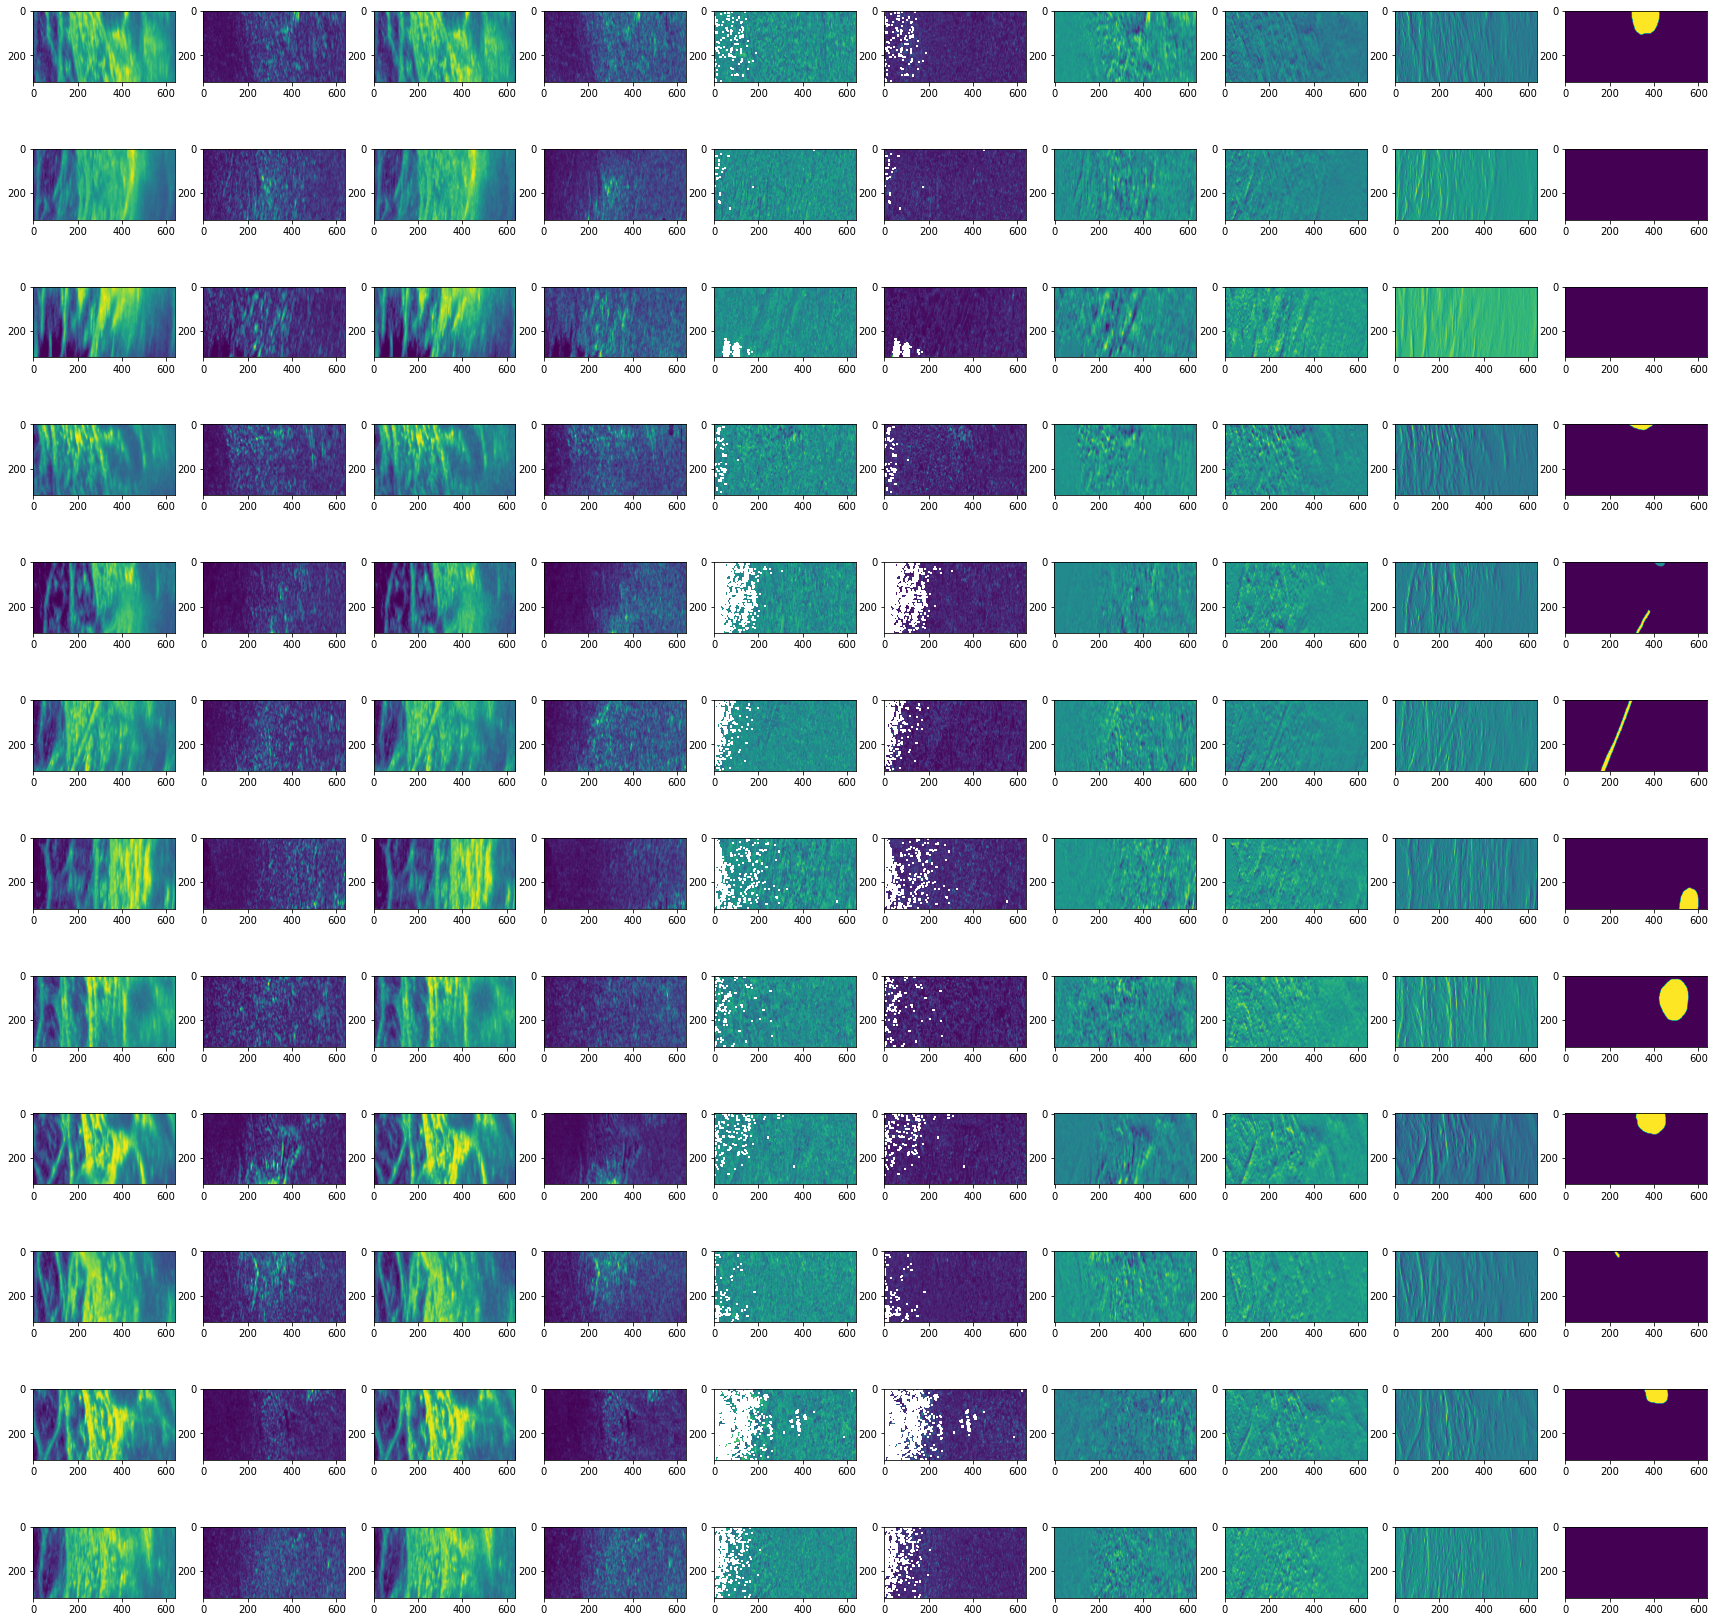

In [8]:
myNetwork.view_vfold_training_batch(1,0)

In [9]:
#myNetwork.train_network_vfold(0)

# 